In [78]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib
The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [79]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

In [80]:
%%cl_kernel 
__kernel void linear_wave_2D(__global float *u2, __global float *u1, __global const float *u0, float c, float dt, float dx, float dy) {
    
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    //Skip ghost cells
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i;
    int south = (j-1)*nx + i;
    int east = j*nx + (i+1);
    int west = j*nx + (i-1);
    
    //Internal cells
    if (i > 0 && i < nx-1 && j > 0 && j < ny-1) {
        u2[center] = 2*u1[center] - u0[center]
        + (c*(dt*dt)/(dx*dx) * (u1[west] - 2*u1[center] + u1[east]))
        + (c*(dt*dt)/(dy*dy) * (u1[south] - 2*u1[center] + u1[north]));
    }
}

In [81]:
%%cl_kernel
__kernel void linear_wave_2D_bc(__global float* u){
    
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    //Skip ghost cells
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i;
    int south = (j-1)*nx + i;
    int east = j*nx + (i+1);
    int west = j*nx + (i-1);
    
    //Boundary conditions (ghost cells)
    if (i == 0) {
        u[center] = u[east];
    }
    else if (i == nx-1) {
        u[center] = u[west]; 
    }
    else if (j == 0) { 
        u[center] = u[north];
    }
    else if (j == ny-1) {
        u[center] = u[south]; 
    }
}

In [82]:
"""
Class that holds data for the heat equation in OpenCL
"""
class WaveDataCL:
    """
    Uploads initial data to the CL device
    """
    def __init__(self, u0):
        #Make sure that the data is single precision floating point
        assert(np.issubdtype(u0.dtype, np.float32))
        
        #Find number of cells
        self.nx = u0.shape[0] # number of cells at x dimm
        self.ny = u0.shape[1] # number of cells at y dimm
        
        mf = cl.mem_flags 
        
        #Upload data to the device (Input Buffer)
        self.u0 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Upload data to the device (Input Buffer)
        self.u1 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Allocate output buffers
        self.u2 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        
    """
    Enables downloading data from CL device to Python
    """
    def download(self):
        #Allocate data on the host for result
        u0 = np.empty((self.nx, self.ny), dtype=np.float32)
        
        #Copy data from device to host
        cl.enqueue_copy(cl_queue, u0, self.u0)
        
        #Return
        return u0;

In [83]:
"""
Computes the heat equation using an explicit finite difference scheme with OpenCL
"""
def opencl_linear_wave_eq(cl_data, c, dx, dy, nt):
    #Calculate dt from the CFL condition
    dt = 0.4 * min(dx*dx / (2.0*c), dy*dy / (2.0*c))

    #Loop through all the timesteps
    for i in range(nt):
        #Execute program on device
        linear_wave_2D(cl_queue, (cl_data.nx, cl_data.ny), None, cl_data.u2, cl_data.u1, cl_data.u0, numpy.float32(c), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
        
        #Impose boundary conditions
        linear_wave_2D_bc(cl_queue, (cl_data.nx, cl_data.ny), None, cl_data.u2)
        
        #Swap variables
        cl_data.u0, cl_data.u1, cl_data.u2 = cl_data.u1, cl_data.u2, cl_data.u0

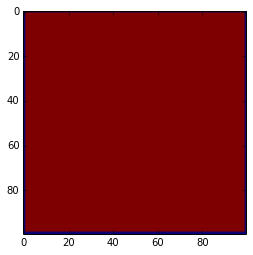

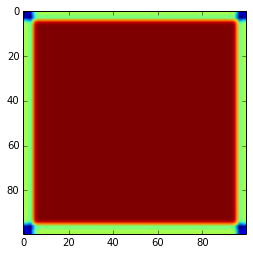

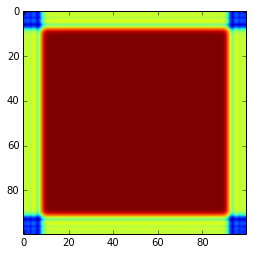

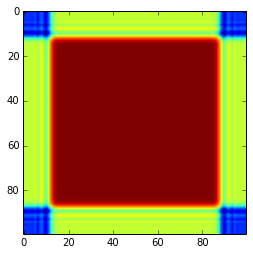

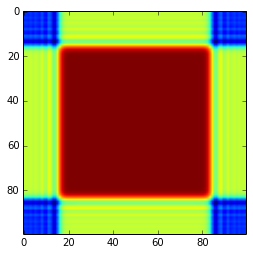

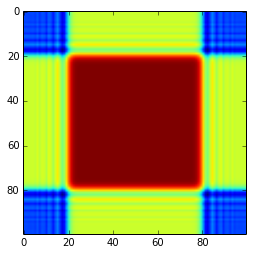

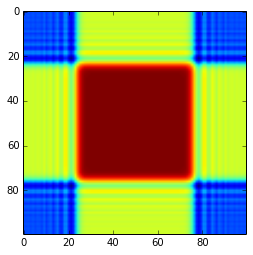

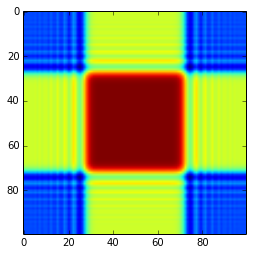

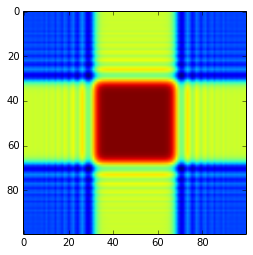

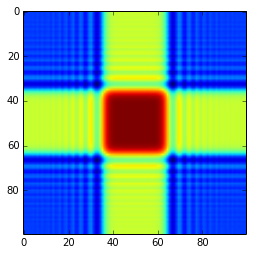

In [92]:
nx = 100
ny = nx

#Create test input data
u0 = np.zeros((ny, nx)).astype(np.float32)

#fill the center of the wave surface
for i in range(1, nx-1):
    for j in range(1, nx-1):
        u0[i, j] = 1;

cl_data = WaveDataCL(u0)
c = 1.0
dx = 1.0
dy = 1.0

#Plot initial conditions
figure()
imshow(u0)

#plot(u0, legend="u0") // only for plotting lines and curves

# put less than 20 iterations
for i in range(1, 10):
    
    # nt parameter at opencl_linear_wave_eq, t times to calculate and plot the results
    timesteps_per_plot = 20
    
    #Simulate 10 timesteps
    opencl_linear_wave_eq(cl_data, c, dx, dy, timesteps_per_plot)

    #Download data
    data_dl = cl_data.download()

    #Plot
    figure() # display on separate img
    imshow(data_dl)
    
#legend()